# RNN of an Auto-Regressive Process

In [1]:
# data wrangling
import pandas as pd 
import numpy as np

from sklearn.preprocessing import MinMaxScaler

# pytorch framework
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils

# pytorch-lightning framework
import pytorch_lightning as pl

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

# utils
import os
import shutil

# Data wrangling

## Generating and Preparing Data

<AxesSubplot:xlabel='n', ylabel='y'>

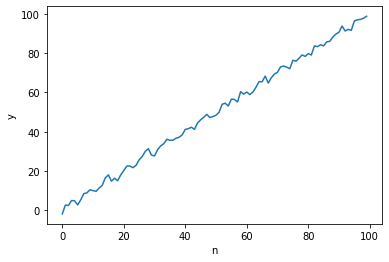

In [2]:
n = 100
rng = np.random.default_rng()
x = np.sin(range(n))
white_noise = rng.normal(0,1, n)

def ar1_seq(original_seq, coef, noise):
    """ Create a autoregressive of 1 step given an original sequence.
    y[n] = coef*y[n-1] + noise.

    returns: numpy.array
    """
    y = []
    for index, value in enumerate(original_seq):
        new_value =  value + coef*x[index - 1]
        y.append(new_value)

    y = np.array(y) + noise

    return(y)


y = ar1_seq(x, 0.5, white_noise)
y = np.arange(y.shape[0]) + y

# Check plotting data
df = pd.DataFrame({
    'y': y,
    'n': range(n)
})

sns.lineplot(data=df, x='n', y='y')

<AxesSubplot:>

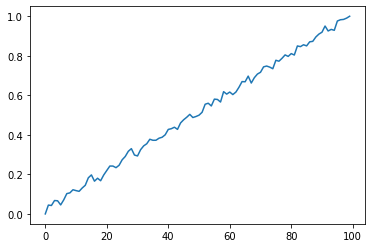

In [3]:
minmax = MinMaxScaler()

minmax.fit(df['y'].to_numpy().reshape(-1, 1))

df['y'] = pd.Series(minmax.transform(df['y'].to_numpy().reshape(-1, 1)).reshape(-1))

df['y'].plot()

## building dataloaders

In [4]:
class ToTensor(object):
    def __call__(self, sample):
        return torch.from_numpy(sample).float()


class SequenceData(Dataset):
    def __init__(self, y:np.array, transform=None, k:int=1, forecast=False):
        
        self.y = y.copy()
        self.transform = transform
        self.k = k
        self.forecast = forecast
    
    def __len__(self):
        return len(self.y)-self.k
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        k = self.k
        sample = {}
        if not self.forecast:
            sample['y'] = self.y[[idx+k]]
        sample['x'] = self.y[(idx):(idx+k)]

        if self.transform:
            sample['x'] = self.transform(sample['x'])
            if sample.get('y'):
                sample['y'] = self.transform(sample['y'])
        
        return sample
        
K = 3
seq_dataset = SequenceData(
    y = df['y'].to_numpy(),
    transform=ToTensor(),
    k = K
)

for index, i in enumerate(seq_dataset):
    y, x = i['y'], i['x']
    print(df['y'].iloc[index:(index + K + 1)])
    print(x, y)
    if index == 2:
        break

0    0.000000
1    0.044622
2    0.042701
3    0.067662
Name: y, dtype: float64
tensor([0.0000, 0.0446, 0.0427]) tensor([0.0677])
1    0.044622
2    0.042701
3    0.067662
4    0.066474
Name: y, dtype: float64
tensor([0.0446, 0.0427, 0.0677]) tensor([0.0665])
2    0.042701
3    0.067662
4    0.066474
5    0.045569
Name: y, dtype: float64
tensor([0.0427, 0.0677, 0.0665]) tensor([0.0456])


In [5]:
dataset_dict = {
    'train': (
        SequenceData(
            y = df['y'][:-20].to_numpy(),
            transform=ToTensor(),
            k = K
        )
    ),
    'val': (
        SequenceData(
            y = df['y'][-20:].to_numpy(),
            transform=ToTensor(),
            k = K
        )
    )
}

# Modelling

In [6]:
class RNN(pl.LightningModule):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, dataset_dict):
        super(RNN, self).__init__()

        self.dataset_dict = dataset_dict

        self.criterion = nn.MSELoss()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.input_size = input_size

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # rnn_out_raw (batch_size, seq_length, hidden_dim)
        # rnn_out (batch_size * seq_length, hidden_dim)

        # input size of 1
        x = x.unsqueeze(-1)

        outs, hidden = self.rnn(x)
        # get the last hidden output with the "hidden" variable
        rnn_out = hidden.reshape(-1, self.hidden_dim)
        
        output = self.fc(rnn_out)
        
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch['x'], batch['y']

        y_hat= self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch['x'], batch['y']

        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        return optimizer
    
    def train_dataloader(self):
        return DataLoader(
            self.dataset_dict['train'],
            batch_size=1,
            num_workers=os.cpu_count(),
            shuffle=False
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.dataset_dict['val'],
            batch_size=1,
            num_workers=os.cpu_count(),
            shuffle=False
        )

model = RNN(
    input_size=1,
    output_size=1,
    hidden_dim=2,
    n_layers=1,
    dataset_dict=dataset_dict
    
)

shutil.rmtree('../lightning_logs', ignore_errors=True)

trainer = pl.Trainer(
    default_root_dir='../',
    log_every_n_steps=5,
    max_epochs=20,
    enable_progress_bar=True
)

trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | rnn       | RNN     | 10    
2 | fc        | Linear  | 3     
--------------------------------------
13        Trainable params
0         Non-trainable params
13        Total params
0.000     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 94/94 [00:00<00:00, 109.19it/s, loss=0.000387, v_num=0, val_loss=0.001]   


# Forecasting

In [7]:
@torch.no_grad()
def forecast(model, x, k=1):
    x = x.reshape(1, -1)
    yhat, hidden = model(x)

    if k == 1:
        return yhat.numpy().flatten()

    yhat_results = np.zeros(k)
    yhat_results[0] = yhat

    print('0', x)
    old = x.clone()
    new = x.clone()
    for i in range(1, k):
        new[:, 0:2] = old[:, 1:3]
        new[:, -1] = yhat
        print(i, new)

        yhat, hidden = model(new)
        yhat = yhat

        old = new.clone()

        yhat_results[i] = yhat

    return yhat_results

torch.Size([77, 1]) torch.Size([77, 3])
torch.Size([77, 1])


<AxesSubplot:>

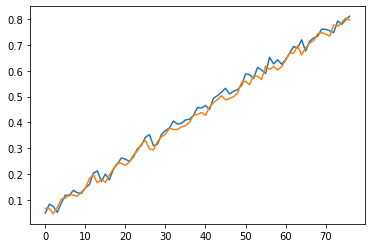

In [8]:
for i in DataLoader(
    dataset_dict['train'],
    batch_size=len(dataset_dict['train']),
    num_workers=os.cpu_count(),
    shuffle=False
):
    y_train, x_train = i['y'], i['x']
    print(y_train.shape, x_train.shape)

with torch.no_grad():
    out = model(x_train)
    print(out.shape)

pd.Series(out.numpy().flatten()).plot()
pd.Series(y_train.numpy().flatten()).plot()

torch.Size([17, 1]) torch.Size([17, 3])
torch.Size([17, 1])


<AxesSubplot:>

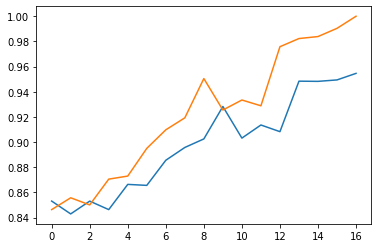

In [9]:
for i in DataLoader(
    dataset_dict['val'],
    batch_size=len(dataset_dict['val']),
    num_workers=os.cpu_count(),
    shuffle=False
):
    y_val, x_val = i['y'], i['x']
    print(y_val.shape, x_val.shape)

with torch.no_grad():
    out = model(x_val)
    print(out.shape)

pd.Series(out.numpy().flatten()).plot()
pd.Series(y_val.numpy().flatten()).plot()